In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Ex. 8

In [178]:
X = np.random.normal(size=100)
eps = np.random.normal(size=100)
y = 3 + 5 * X - 4 * X ** 2 + X ** 3 + eps

In [179]:
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor, as_completed
import statsmodels.api as sm

def test_k(X, y, k):
    models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(X.columns, k)]
    return k, max(models, key=lambda model: model[1])[0]

def best_subset_selection(X, y, max_jobs=None, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    
    with ProcessPoolExecutor(max_workers=max_jobs) as executor:
        
        futures = [executor.submit(test_k, X, y, k) for k in range(1, p + 1)]
        for future in as_completed(futures):
            best_of_k[future.result()[0]] = future.result()[1]
            if verbose:
                print(future.result()[0], future.result()[1])
        
    return best_of_k

In [180]:
def forward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    for k in range(1, p + 1):
        names_candidates = [best_of_k[k - 1] + [name] for name in X.columns if name not in best_of_k[k - 1]]
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in names_candidates]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [181]:
def backward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[p] = X.columns.tolist()
    best_of_k[0] = []

    for k in range(p - 1, 0, -1):
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(best_of_k[k+1], k)]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [182]:
def evaluate(best_of_k, X, y):
    metrics = pd.DataFrame(columns=['RSS', 'R_squared_adj', 'AIC', 'BIC'])

    for k, names in best_of_k.items():
        if k == 0:
            model = sm.OLS(y, np.ones(y.shape)).fit()
        else:
            model = sm.OLS(y, sm.add_constant(X[list(names)])).fit()
        metrics.loc[k] = [model.ssr, model.rsquared_adj, model.aic, model.bic]
    metrics.sort_index(inplace=True)

    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, col in enumerate(metrics.columns):
        sns.pointplot(metrics.index, metrics[col], marker='o', ax=axes[i%2, i//2], label=col,)
        best = metrics[col].argmax() if col == 'R_squared_adj' else metrics[col].argmin()
        axes[i%2, i//2].set_title(f'Best: {best}')
        sns.scatterplot([best], [metrics[col][best]], marker='o', s=200, color='m', ax=axes[i%2, i//2])

In [183]:
data = pd.DataFrame()
for i in range(1, 11):
    data[f'X^{i}'] = X ** i
y = pd.Series(y)

In [184]:
%%time
best_models = best_subset_selection(data, y)

1 ('X^3',)
9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
10 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
2 ('X^1', 'X^2')
8 ('X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^10')
7 ('X^1', 'X^2', 'X^3', 'X^5', 'X^6', 'X^7', 'X^9')
3 ('X^1', 'X^2', 'X^3')
6 ('X^1', 'X^2', 'X^3', 'X^6', 'X^7', 'X^9')
4 ('X^1', 'X^2', 'X^5', 'X^7')
5 ('X^1', 'X^2', 'X^3', 'X^5', 'X^9')
CPU times: user 28.9 ms, sys: 60.5 ms, total: 89.3 ms
Wall time: 956 ms


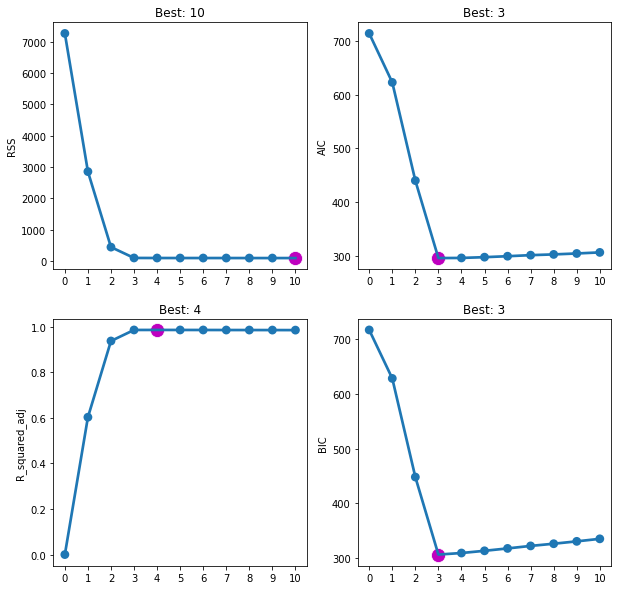

In [185]:
evaluate(best_models, data, y)

All scores show that model with 3 predictors is the best one.

In [186]:
model = sm.OLS(y, sm.add_constant(data[['X^1', 'X^2', 'X^3']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2205.
Date:                Wed, 16 Sep 2020   Prob (F-statistic):           2.28e-88
Time:                        11:16:46   Log-Likelihood:                -143.80
No. Observations:                 100   AIC:                             295.6
Df Residuals:                      96   BIC:                             306.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8078      0.131     21.450      0.000       2.548       3.068
X^1            4.8837      0.183     26.684      0.000       4.520       5.247
X^2           -3.8370      0.083    -46.054      0.000      -4.002      -3.672
X^3            1.0014      0.056     17.864      0.000       0.890       1.113
==============================================================================
Omnibus:                        4.333   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.834
Skew:                          -0.340   Prob(JB):                        0.147
Kurtosis:                       3.677   Cond. No.                         6.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All coefficient are good estimations of real ones.

1 ['X^3']
2 ['X^3', 'X^2']
3 ['X^3', 'X^2', 'X^1']
4 ['X^3', 'X^2', 'X^1', 'X^10']
5 ['X^3', 'X^2', 'X^1', 'X^10', 'X^8']
6 ['X^3', 'X^2', 'X^1', 'X^10', 'X^8', 'X^5']
7 ['X^3', 'X^2', 'X^1', 'X^10', 'X^8', 'X^5', 'X^9']
8 ['X^3', 'X^2', 'X^1', 'X^10', 'X^8', 'X^5', 'X^9', 'X^7']
9 ['X^3', 'X^2', 'X^1', 'X^10', 'X^8', 'X^5', 'X^9', 'X^7', 'X^6']
10 ['X^3', 'X^2', 'X^1', 'X^10', 'X^8', 'X^5', 'X^9', 'X^7', 'X^6', 'X^4']
CPU times: user 384 ms, sys: 285 µs, total: 384 ms
Wall time: 375 ms


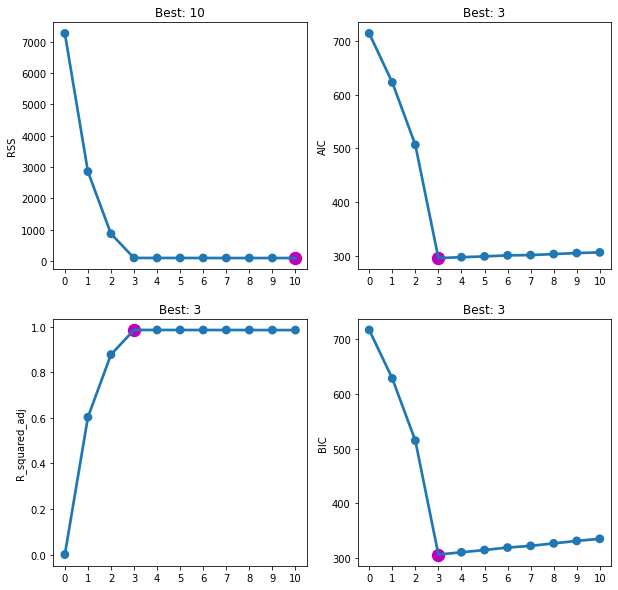

In [187]:
%%time
best_models = forward_stepwise_selection(data, y)
evaluate(best_models, data, y)

9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
8 ('X^1', 'X^2', 'X^3', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
7 ('X^1', 'X^2', 'X^3', 'X^6', 'X^7', 'X^8', 'X^9')
6 ('X^1', 'X^2', 'X^3', 'X^6', 'X^7', 'X^9')
5 ('X^1', 'X^2', 'X^3', 'X^7', 'X^9')
4 ('X^1', 'X^2', 'X^3', 'X^9')
3 ('X^1', 'X^2', 'X^3')
2 ('X^1', 'X^2')
1 ('X^1',)
CPU times: user 391 ms, sys: 441 µs, total: 391 ms
Wall time: 384 ms


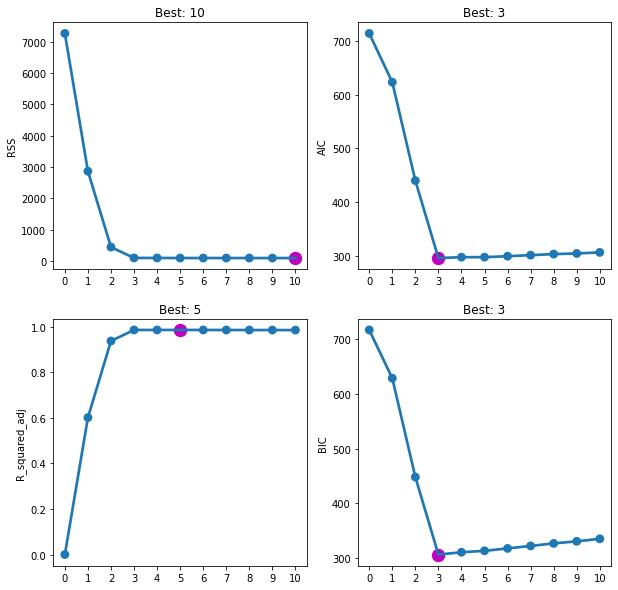

In [188]:
%%time
best_models = backward_stepwise_selection(data, y)
evaluate(best_models, data, y)

Results for forward stepwise selection is the same as with best subset selection. Backward stepwise selection has worse results. It had removed the third predictor almost at start.

In [189]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse

In [190]:
data = data / data.std()

In [191]:
lambdas = np.logspace(-3, 1, 20).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=10)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(data):
        model = Lasso(alpha=l, normalize=False, max_iter=2000).fit(data.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(data.iloc[test])))
    res.loc[l] = np.mean(lambda_res)

0.048


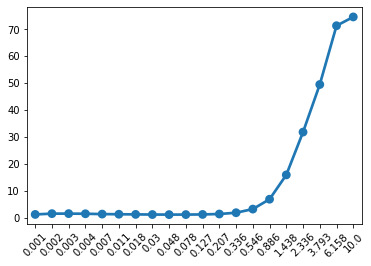

In [192]:
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [193]:
best_model = Lasso(alpha=best, normalize=False).fit(data, y)
best_model.coef_

array([ 4.75471598, -4.82065658,  3.16385744, -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ])

The coeficients show that lasso was able to cut almost all unrelated variables. But also remaining coeficients differ a little from original ones.

In [194]:
np.random.seed(1)
X = np.random.normal(size=500)
eps = np.random.normal(size=500)
y = 8 + 12 * X ** 7 + eps
data = pd.DataFrame()
for i in range(1, 11):
    data[f'X^{i}'] = X ** i
y = pd.Series(y)

1 ('X^7',)
9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9')
10 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
2 ('X^7', 'X^10')
8 ('X^1', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9')
3 ('X^2', 'X^6', 'X^7')
7 ('X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9')
4 ('X^4', 'X^6', 'X^7', 'X^8')
6 ('X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^10')
5 ('X^2', 'X^3', 'X^4', 'X^5', 'X^7')
CPU times: user 230 ms, sys: 72.4 ms, total: 303 ms
Wall time: 1.19 s


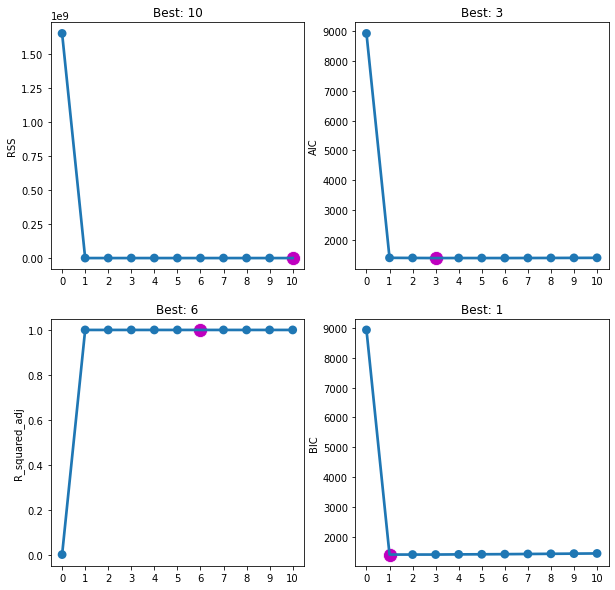

In [195]:
%%time
best_models = best_subset_selection(data, y)
evaluate(best_models, data, y)

In [196]:
model = sm.OLS(y, sm.add_constant(data[['X^7']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.737e+09
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:16:51   Log-Likelihood:                -695.58
No. Observations:                 500   AIC:                             1395.
Df Residuals:                     498   BIC:                             1404.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0242      0.044    184.110      0.000       7.939       8.110
X^7           12.0002      0.000   4.17e+04      0.000      12.000      12.001
==============================================================================
Omnibus:                        5.024   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                6.141
Skew:                          -0.086   Prob(JB):                       0.0464
Kurtosis:                       3.515   Cond. No.                         151.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results are as expected.

24.421


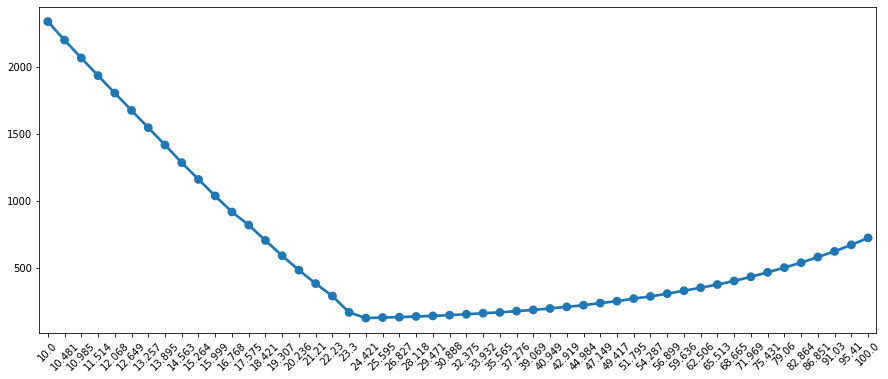

In [197]:
# data = data / data.std()
lambdas = np.logspace(1, 2, 50).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=2)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(data):
        model = Lasso(alpha=l).fit(data.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(data.iloc[test])))
    res.loc[l] = np.mean(lambda_res)
    
plt.figure(figsize=(15, 6))
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [198]:
train_X, test_X, train_y, test_y = train_test_split(data, y, test_size=0.25, random_state=3)
best_lasso = Lasso(alpha=best, normalize=False).fit(train_X, train_y)
best_bss = sm.OLS(train_y, sm.add_constant(train_X[['X^7']])).fit()
best_lasso.intercept_, best_lasso.coef_

(8.029958631061426,
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.04293365e+00,  1.07053952e-02,  1.12021278e+01,  0.00000000e+00,
         6.71291893e-02, -1.33345881e-03]))

In [199]:
print('Lasso:', mse(test_y, best_lasso.predict(test_X)))
print('BSS  :', mse(test_y, best_bss.predict(sm.add_constant(test_X[['X^7']]))))

Lasso: 10.745633952286234
BSS  : 0.8083075141056256


Lasso had left too much unnecessary variables.

# Ex. 9

In [350]:
dataset_file = '../datasets/College.csv'
data = pd.read_csv(dataset_file)
data.Private = data.Private.apply(lambda v: 1 if v == 'Yes' else 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    int64  
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(17)
memory usage: 109.4 KB


In [351]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [352]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=1)

train_X = train_data.drop(['Apps'], axis=1)
test_X = test_data.drop(['Apps'], axis=1)
train_y = train_data.Apps
test_y = test_data.Apps

std_train_X = train_X / train_X.std()
std_test_X = test_X / test_X.std()

errors = pd.Series(dtype=np.float64)
R_squared = pd.Series(dtype=np.float64)

In [353]:
least_squares_model = LinearRegression().fit(std_train_X, train_y)
least_squres_pred = least_squares_model.predict(std_test_X)
errors['Least Squares'] = mse(test_y, least_squres_pred)
R_squared['Least Squares'] = r2_score(test_y, least_squres_pred)
errors['Least Squares']

874031.7127195646

0.01


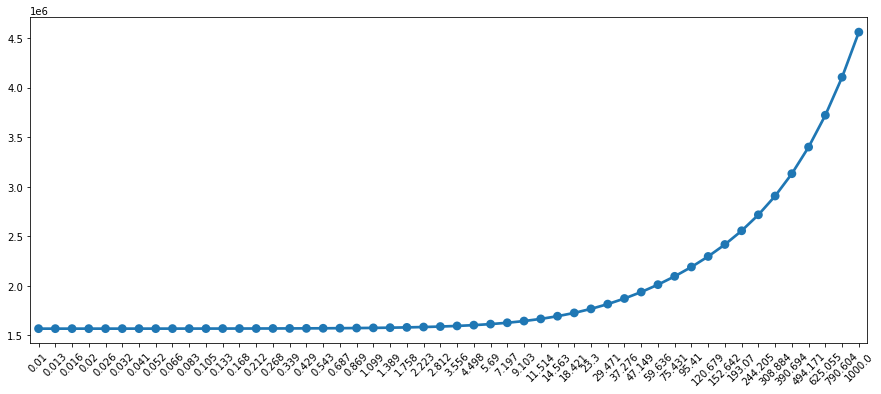

In [354]:
lambdas = np.logspace(-2, 3, 50).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(std_train_X):
        model = Ridge(alpha=l).fit(std_train_X.iloc[train], train_y.iloc[train])
        lambda_res.append(mse(train_y.iloc[test], model.predict(std_train_X.iloc[test])))
    res.loc[l] = np.mean(lambda_res)
    
plt.figure(figsize=(15, 6))
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [355]:
ridge_model = Ridge(alpha=best).fit(std_train_X, train_y)
ridge_pred = ridge_model.predict(std_test_X)
errors['Ridge'] = mse(test_y, ridge_pred)
R_squared['Ridge'] = r2_score(test_y, ridge_pred)
errors['Ridge']

873959.581894939

14.563


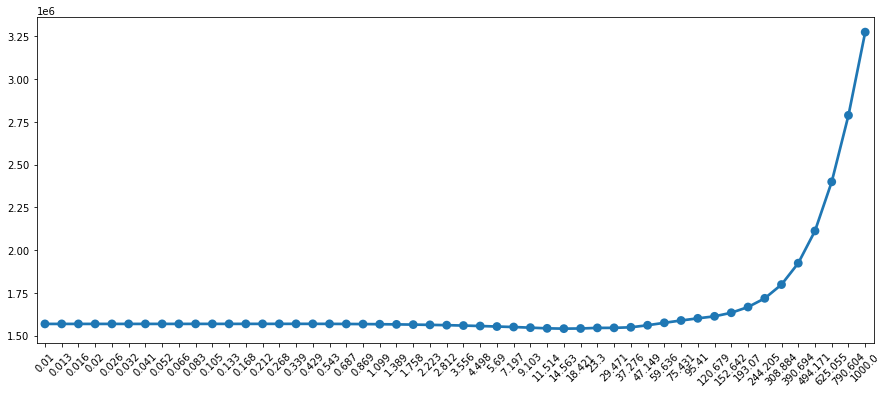

In [356]:
lambdas = np.logspace(-2, 3, 50).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(std_train_X):
        model = Lasso(alpha=l).fit(std_train_X.iloc[train], train_y.iloc[train])
        lambda_res.append(mse(train_y.iloc[test], model.predict(std_train_X.iloc[test])))
    res.loc[l] = np.mean(lambda_res)
    
plt.figure(figsize=(15, 6))
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [357]:
lasso_model = Lasso(alpha=best).fit(std_train_X, train_y)
print('Non zero:', lasso_model.coef_.nonzero()[0].size)
lasso_pred = lasso_model.predict(std_test_X)
errors['Lasso'] = mse(test_y, lasso_pred)
R_squared['Lasso'] = r2_score(test_y, lasso_pred)
errors['Lasso']

Non zero: 14


833445.2827955148

In [358]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

17


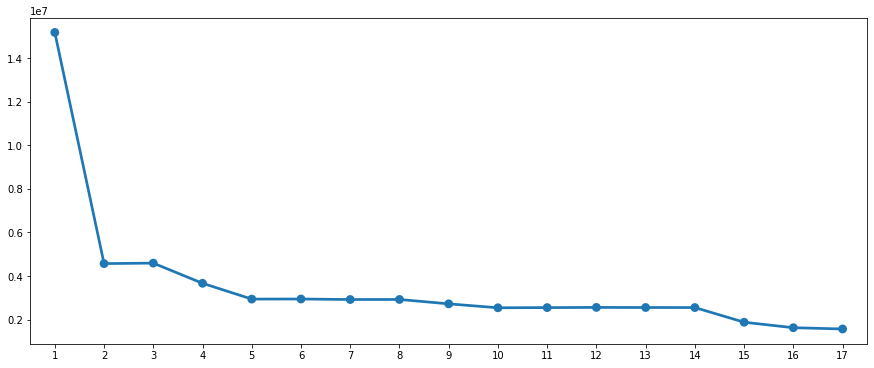

In [359]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)

res = pd.Series(index=pd.RangeIndex(1, std_train_X.shape[1]), dtype=np.float64)
pca = PCA()
X_reduced_train = pca.fit_transform(std_train_X)
for num_components in range(1, X_reduced_train.shape[1] + 1):
    cv_scores = []
    for train, test in cv.split(X_reduced_train):
        model = LinearRegression().fit(X_reduced_train[train, :num_components], train_y.iloc[train])
        cv_scores.append(mse(train_y.iloc[test], model.predict(X_reduced_train[test, :num_components])))
    res.loc[num_components] = np.mean(cv_scores)

plt.figure(figsize=(15, 6))
sns.pointplot(res.index, res)
best = res.index[res.argmin()]
print(best)

In [360]:
X_reduced_test = pca.transform(std_test_X)
pcr_model_17 = LinearRegression().fit(X_reduced_train[:, :best], train_y)
pcr_pred_17 = pcr_model_17.predict(X_reduced_test[:, :best])
errors['PCR_17'] = mse(test_y, pcr_pred_17)
R_squared['PCR_17'] = r2_score(test_y, pcr_pred_17)

pcr_model_10 = LinearRegression().fit(X_reduced_train[:, :10], train_y)
pcr_pred_10 = pcr_model_10.predict(X_reduced_test[:, :10])
errors['PCR_10'] = mse(test_y, pcr_pred_10)
R_squared['PCR_10'] = r2_score(test_y, pcr_pred_10)

errors[['PCR_17', 'PCR_10']]

PCR_17    8.740317e+05
PCR_10    1.421202e+06
dtype: float64

17


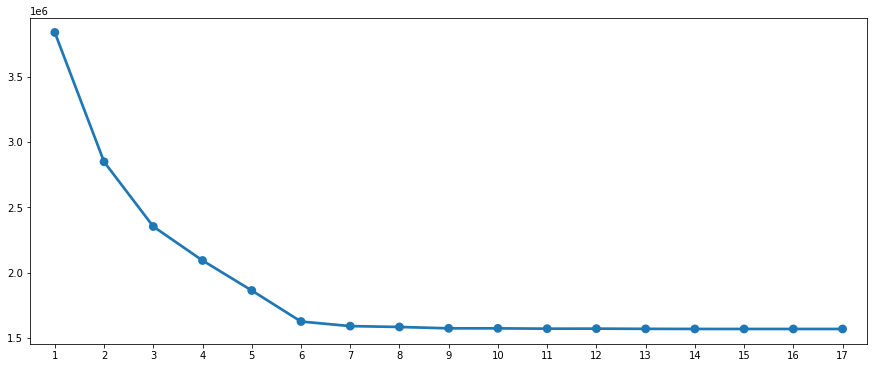

In [361]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)

res = pd.Series(index=pd.RangeIndex(1, std_train_X.shape[1]), dtype=np.float64)
for num_components in range(1, std_train_X.shape[1] + 1):
    cv_scores = []
    for train, test in cv.split(std_train_X):
        model = PLSRegression(n_components=num_components).fit(std_train_X.iloc[train], train_y.iloc[train])
        cv_scores.append(mse(train_y.iloc[test], model.predict(std_train_X.iloc[test])))
    res.loc[num_components] = np.mean(cv_scores)

plt.figure(figsize=(15, 6))
sns.pointplot(res.index, res)
best = res.index[res.argmin()]
print(best)

In [362]:
plsr_model_17 = PLSRegression(n_components=best).fit(std_train_X, train_y)
plsr_pred_17 = plsr_model_17.predict(std_test_X)
errors['PLSR_17'] = mse(test_y, plsr_pred_17)
R_squared['PLSR_17'] = r2_score(test_y, plsr_pred_17)

plsr_model_9 = PLSRegression(n_components=9).fit(std_train_X, train_y)
plsr_pred_9 = plsr_model_9.predict(std_test_X)
errors['PLSR_9'] = mse(test_y, plsr_pred_9)
R_squared['PLSR_9'] = r2_score(test_y, plsr_pred_9)

errors[['PLSR_17', 'PLSR_9']]

PLSR_17    874031.71272
PLSR_9     842831.86992
dtype: float64

In [363]:
errors

Least Squares    8.740317e+05
Ridge            8.739596e+05
Lasso            8.334453e+05
PCR_17           8.740317e+05
PCR_10           1.421202e+06
PLSR_17          8.740317e+05
PLSR_9           8.428319e+05
dtype: float64

In [364]:
R_squared

Least Squares    0.931927
Ridge            0.931933
Lasso            0.935088
PCR_17           0.931927
PCR_10           0.889311
PLSR_17          0.931927
PLSR_9           0.934357
dtype: float64

The results show that there is not much difference among models. Ridge regression performs almost the same as Least Squares. Lasso had managed to cut out 3 variables and has the best R squared value on test data. PCR was unable to perform any useful dimentionality reduction, using 10 component gives a huge decrease in model performance. PLSR CV shows that the model with all 17 components is the best, however one can effectivly use only 8 or 9 components without a substantial decrease in model performance.